In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly
# import plotly_express as px
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from scipy import stats
from xgboost import XGBClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, accuracy_score

from sklearn import tree
import graphviz

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import RandomOverSampler

from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import RepeatedEditedNearestNeighbours
from imblearn.under_sampling import AllKNN
from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.under_sampling import OneSidedSelection
from imblearn.under_sampling import NeighbourhoodCleaningRule

from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek

from sklearn.neighbors import KNeighborsClassifier 

import seaborn as sns

%matplotlib inline

Считываем все файлы

In [2]:
df_sales_train = pd.read_csv('/Users/roman/Desktop/1C Kaggle/sales_train.csv')
df_item_categories = pd.read_csv('/Users/roman/Desktop/1C Kaggle/item_categories.csv')
df_items = pd.read_csv('/Users/roman/Desktop/1C Kaggle/items.csv')
df_shops = pd.read_csv('/Users/roman/Desktop/1C Kaggle/shops.csv')
df_test = pd.read_csv('/Users/roman/Desktop/1C Kaggle/test.csv')

Так как item_cnt_day содержит отрицательные значения (возврат товара), убираем их, чтобы они не путали модель. Факт продажи уже был учтен в данных один раз.

In [3]:
df_sales_train = df_sales_train[df_sales_train['item_cnt_day'] > 0]

Соединяем отдельные файлы в один dataframe

In [4]:
total = pd.merge(df_sales_train, df_items, how='left', left_on='item_id', right_on='item_id')
total = pd.merge(total, df_item_categories, how='left', left_on='item_category_id', right_on='item_category_id')
item = total['item_category_id'].unique()
shop = total['shop_id'].unique()

Выделяем категории товаров/услуг. Так как могут быть разные предпосылки продаж для каждой категории. Для анализа возьмем категорию "Кино"

In [5]:
lst = []
for i in range(len(item)):
    first_predict = total[(total['item_category_id'] == item[i])][['date_block_num', 'shop_id', 'item_id', 'item_cnt_day', 'item_category_id', 'item_category_name', 'item_name']]
    lst.append(first_predict)
df = pd.concat(lst)

films = lst[0]

Встречаются товары, которые были проданы больше одного раза при тех же признаках, что и раньше(в одном магазине, в одном месяце), поэтому заменим такие продажи одним общим значением - максимальное количество продаж

In [6]:
films = films.groupby(by=['shop_id', 'date_block_num','item_id']).agg({'item_cnt_day': np.max}).reset_index()
films['item_cnt_day'] = films['item_cnt_day'].apply(int)
films['date_block_num'] = films['date_block_num'].apply(lambda x: x % 12 + 1)

Разметим классы одна продажа и больше одной продажи. При разбивке на большее количество классов модель показывала плохой прогноз, поэтому принято решение разбить на два класса из-за несбалансированности выборки

In [7]:
def get_class_films(count_sales):
    if count_sales < 0:
        return 0
    if count_sales == 1:
        return count_sales 
    if count_sales > 1:
        return 2
    return count_sales

Добавляем новый столбец с классами и удаляем предыдущий

In [8]:
films['class_item_cnt_day'] = films['item_cnt_day'].apply(get_class_films)
films = films.drop('item_cnt_day', axis=1)

In [9]:
films['class_item_cnt_day'].value_counts()
print(films['class_item_cnt_day'].value_counts())

1    128792
2      5684
Name: class_item_cnt_day, dtype: int64


Разбиваем нашу выборку на test/train

In [10]:
X_train_first, X_test, y_train_first, y_test = train_test_split(films.drop('class_item_cnt_day', axis=1), films['class_item_cnt_day'], test_size=0.2)

In [11]:
pd.Series(y_train_first).value_counts()

1    103001
2      4579
Name: class_item_cnt_day, dtype: int64

In [12]:
graph_first = pd.concat([X_train_first, y_train_first], axis=1)

In [13]:
def hist(graph):
    fig,ax = plt.subplots(2,3,figsize=(30,7))
    ax1, ax2, ax3, ax4, ax5, ax6 = ax.flatten()
    sns.distplot(graph_first[graph_first['class_item_cnt_day'] == 1]['item_id'], hist=False, bins=30, ax=ax1)
    sns.distplot(graph[graph['class_item_cnt_day'] == 1]['item_id'], hist=False, bins=30, ax=ax1)  
    sns.distplot(graph_first[graph_first['class_item_cnt_day'] == 1]['shop_id'], hist=False, bins=1000, ax=ax2)
    sns.distplot(graph[graph['class_item_cnt_day'] == 1]['shop_id'], hist=False, bins=1000, ax=ax2)
    sns.distplot(graph_first[graph_first['class_item_cnt_day'] == 1]['date_block_num'], hist=False, ax=ax3 )
    sns.distplot(graph[graph['class_item_cnt_day'] == 1]['date_block_num'], hist=False, ax=ax3)
    sns.distplot(graph_first[graph_first['class_item_cnt_day'] == 2]['item_id'], hist=False, bins=30, ax=ax4)
    sns.distplot(graph[graph['class_item_cnt_day'] == 2]['item_id'], hist=False, bins=30, ax=ax4)  
    sns.distplot(graph_first[graph_first['class_item_cnt_day'] == 2]['shop_id'], hist=False, bins=1000, ax=ax5)
    sns.distplot(graph[graph['class_item_cnt_day'] == 2]['shop_id'], hist=False, bins=1000, ax=ax5)
    sns.distplot(graph_first[graph_first['class_item_cnt_day'] == 2]['date_block_num'], hist=False, ax=ax6 )
    sns.distplot(graph[graph['class_item_cnt_day'] == 2]['date_block_num'], hist=False, ax=ax6)
    return print

In [14]:
# fig, (ax1) = plt.subplots(1,1,figsize=(10,10))
# sns.scatterplot(x='shop_id', y='item_id', data=graph_first, hue='class_item_cnt_day', ax=ax1)

In [15]:
models = [DecisionTreeClassifier(criterion='entropy'), DecisionTreeClassifier(criterion='gini'),
          RandomForestClassifier(criterion='entropy'), RandomForestClassifier(criterion='gini'), 
          KNeighborsClassifier(n_neighbors = 3), KNeighborsClassifier(n_neighbors = 6)]

In [16]:
models_name = ['DecisionTreeClassifier(entropy)', 'DecisionTreeClassifier(gini)',
               'RandomForestClassifier(entropy)', 'RandomForestClassifier(gini)', 
          'KNeighborsClassifier(n_neighbors = 3)', 'KNeighborsClassifier(n_neighbors = 6)']

In [17]:
# def fit_predict(models, X_train,y_train):
#     model = models
#     model = model.fit(X_train,y_train)
#     if isinstance(model, DecisionTreeClassifier):
#         dot_data = tree.export_graphviz(model, out_file=None,
#         feature_names=['shop_id', 'date_block_num','item_id'], filled=True, rounded=True, special_characters=True)
#         graph = graphviz.Source(dot_data)
#         graph.view(filename='/Users/roman/Desktop/1C Kaggle/tree.pdf')
#     y_predict = model.predict(X_test)
#     p = metrics.precision_score(y_predict, y_test, average=None)
#     r = metrics.recall_score(y_predict, y_test, average=None)
#     a = metrics.accuracy_score(y_predict, y_test)
#     s = pd.Series(y_train).value_counts()
#     df = {'precision': pd.Series(p, index=[1, 2]), 'recall': pd.Series(r, index=[1, 2]),
#           'accuracy': pd.Series(a, index=[1, 2]), 'sample': pd.Series(s, index=[1, 2])}
#     df = pd.DataFrame(df)
#     print(df)

In [18]:
def fit_predict(models, X_train,y_train):
    model = models
    model = model.fit(X_train,y_train)
    y_predict = model.predict(X_test)
    p = metrics.precision_score(y_predict, y_test, average=None)
    r = metrics.recall_score(y_predict, y_test, average=None)
    a = metrics.accuracy_score(y_predict, y_test)
    s = pd.Series(y_train).value_counts()
    df = {'precision': pd.Series(p, index=[1, 2]), 'recall': pd.Series(r, index=[1, 2]),
          'accuracy': pd.Series(a, index=[1, 2]), 'sample': pd.Series(s, index=[1, 2])}
    df = pd.DataFrame(df)
    print(df)

In [19]:
for x in range(len(models)):
    print(models_name[x])
    fit_predict(models[x], X_train_first, y_train_first)

DecisionTreeClassifier(entropy)
   precision    recall  accuracy  sample
1   0.961343  0.965310  0.929804  103001
2   0.193665  0.176713  0.929804    4579
DecisionTreeClassifier(gini)
   precision    recall  accuracy  sample
1   0.963204  0.966352  0.932555  103001
2   0.217195  0.201850  0.932555    4579
RandomForestClassifier(entropy)


/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


   precision    recall  accuracy  sample
1   0.980846  0.960585   0.94304  103001
2   0.060633  0.119430   0.94304    4579
RandomForestClassifier(gini)


/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


   precision    recall  accuracy  sample
1   0.981389  0.960606   0.94356  103001
2   0.060633  0.122486   0.94356    4579
KNeighborsClassifier(n_neighbors = 3)
   precision    recall  accuracy  sample
1   0.984064  0.963627    0.9491  103001
2   0.133032  0.263441    0.9491    4579
KNeighborsClassifier(n_neighbors = 6)
   precision    recall  accuracy  sample
1   0.997867  0.960406  0.958507  103001
2   0.039819  0.444444  0.958507    4579


Простое дублирование данных

In [20]:
ros = RandomOverSampler(random_state=1)
X_train, y_train = ros.fit_resample(X_train_first, y_train_first)

Сравниваем (до и после oversampling):
- количество проданных товаров, 
- проданных товаров в магазинах, 
- проданных товаров в каждом месяце

По графику item_id видно, что есть небольшое отклонение в большую сторону в части добавления данных на определенные товары, но не очень критичные. А вот по shop_id и date_block_num отклонения могут быть достаточно существенными. Поэтому необходимо оценить с точки зрения бизнеса, насколько реалистичны данные после oversampling.

<function print>

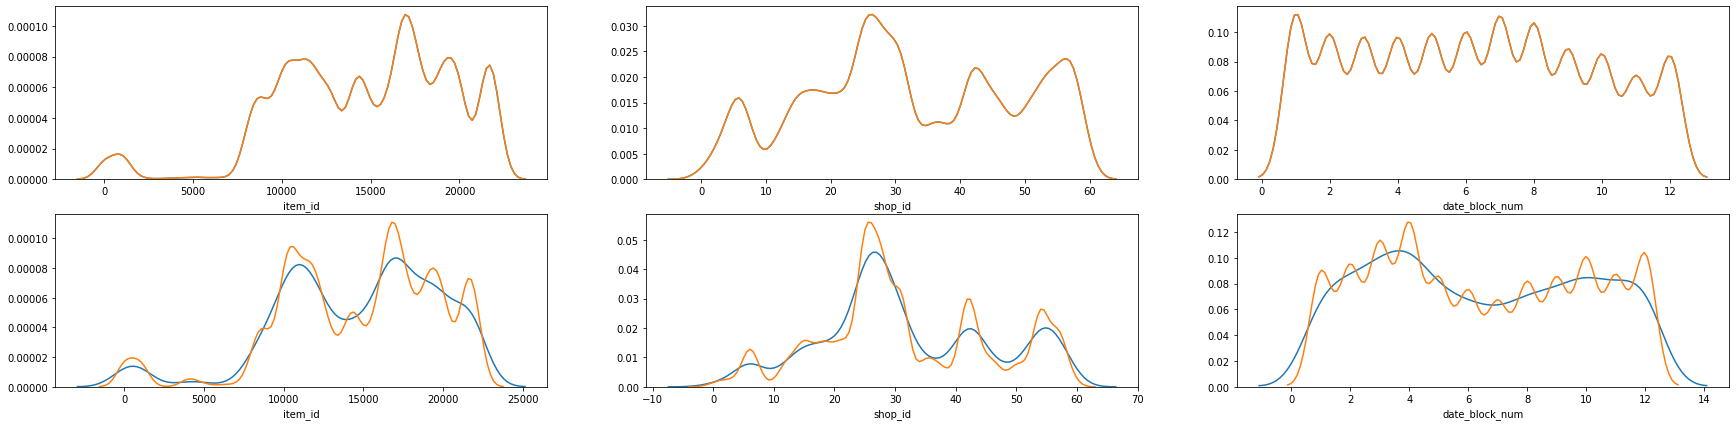

In [21]:
graph_2 = pd.concat([pd.DataFrame(X_train), pd.DataFrame(y_train)], axis=1)
graph_2.columns = ['shop_id', 'date_block_num','item_id', 'class_item_cnt_day']
hist(graph_2)

In [22]:
# fig, (ax1) = plt.subplots(1,1,figsize=(10,10))
# sns.scatterplot(x='shop_id', y='item_id', data=graph_second, hue='class_item_cnt_day', ax=ax1)

In [23]:
for x in range(len(models)):
    print(models_name[x])
    fit_predict(models[x], X_train, y_train)

DecisionTreeClassifier(entropy)
   precision    recall  accuracy  sample
1   0.958358  0.965357   0.92709  103001
2   0.197285  0.168731   0.92709  103001
DecisionTreeClassifier(gini)
   precision    recall  accuracy  sample
1   0.961149  0.965906  0.930213  103001
2   0.208145  0.186688  0.930213  103001
RandomForestClassifier(entropy)
   precision    recall  accuracy  sample
1   0.958707  0.962438  0.924524  103001
2   0.126697  0.116183  0.924524  103001
RandomForestClassifier(gini)
   precision    recall  accuracy  sample
1   0.959792  0.961881   0.92497  103001
2   0.112217  0.106804   0.92497  103001
KNeighborsClassifier(n_neighbors = 3)
   precision    recall  accuracy  sample
1   0.912954  0.974990  0.894073  103001
2   0.453394  0.182447  0.894073  103001
KNeighborsClassifier(n_neighbors = 6)
   precision    recall  accuracy  sample
1   0.887131  0.977151  0.871877  103001
2   0.515837  0.163746  0.871877  103001


In [24]:
Oversampling = [SMOTE(random_state=1), BorderlineSMOTE(random_state = 1, kind = 'borderline-1'), 
                SVMSMOTE(random_state = 1), SMOTENC([0, 1, 2],random_state = 1), ADASYN(random_state = 1)]

Не работате с категориальными признаками. Выбирает соседей рандомно. Самый простой метод.

In [25]:
smote = SMOTE(random_state = 2)
X_train, y_train = smote.fit_resample(X_train_first, y_train_first)
pd.Series(y_train).value_counts()

2    103001
1    103001
dtype: int64

<function print>

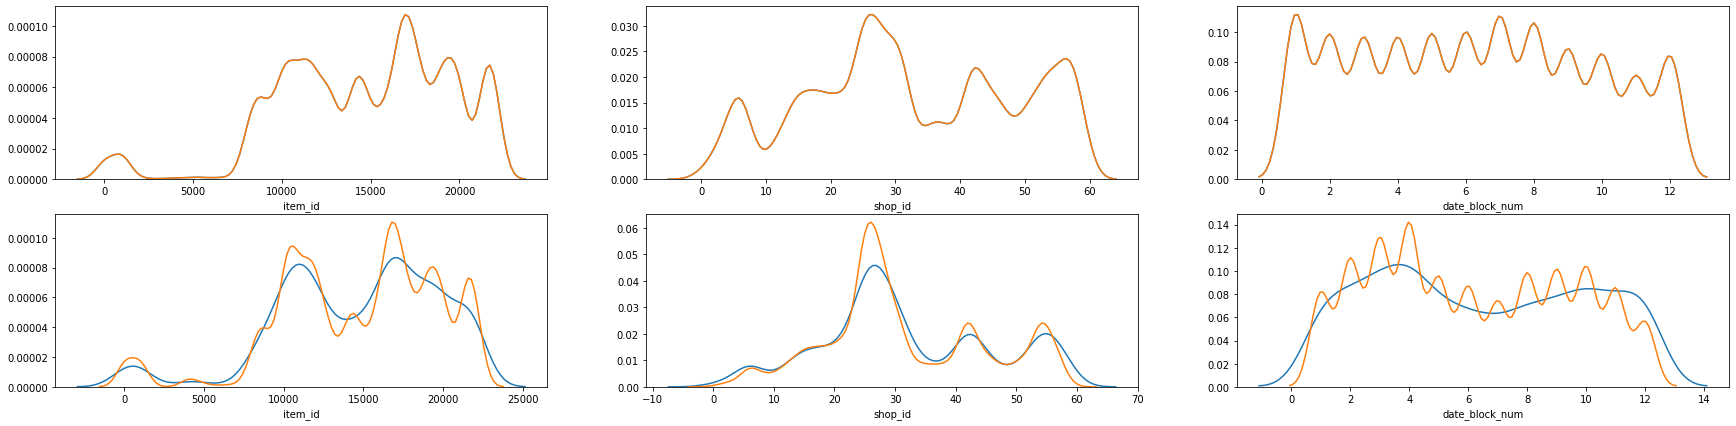

In [26]:
graph_3 = pd.concat([pd.DataFrame(X_train), pd.DataFrame(y_train)], axis=1)
graph_3.columns = ['shop_id', 'date_block_num','item_id', 'class_item_cnt_day']
hist(graph_3)

In [27]:
for x in range(len(models)):
    print(models_name[x])
    fit_predict(models[x], X_train, y_train)

DecisionTreeClassifier(entropy)
   precision    recall  accuracy  sample
1   0.873677  0.975666  0.857971  103001
2   0.491403  0.142857  0.857971  103001
DecisionTreeClassifier(gini)
   precision    recall  accuracy  sample
1   0.873522  0.976253  0.858343  103001
2   0.504072  0.145850  0.858343  103001
RandomForestClassifier(entropy)
   precision    recall  accuracy  sample
1   0.846768  0.974955  0.832206  103001
2   0.492308  0.120996  0.832206  103001
RandomForestClassifier(gini)
   precision    recall  accuracy  sample
1   0.848048  0.974731  0.833209  103001
2   0.486878  0.120709  0.833209  103001
KNeighborsClassifier(n_neighbors = 3)
   precision    recall  accuracy  sample
1   0.850646  0.978721  0.839047  103001
2   0.568326  0.140179  0.839047  103001
KNeighborsClassifier(n_neighbors = 6)
   precision    recall  accuracy  sample
1   0.854949  0.979043   0.84336  103001
2   0.572851  0.144719   0.84336  103001


Учитывает случаи, когда соседи могут быть разных классов. Использует k/2 < m < k (мажоритарный класс)

In [28]:
blsmote = BorderlineSMOTE(random_state = 1, kind = 'borderline-1')
X_train, y_train = blsmote.fit_resample(X_train_first, y_train_first)

<function print>

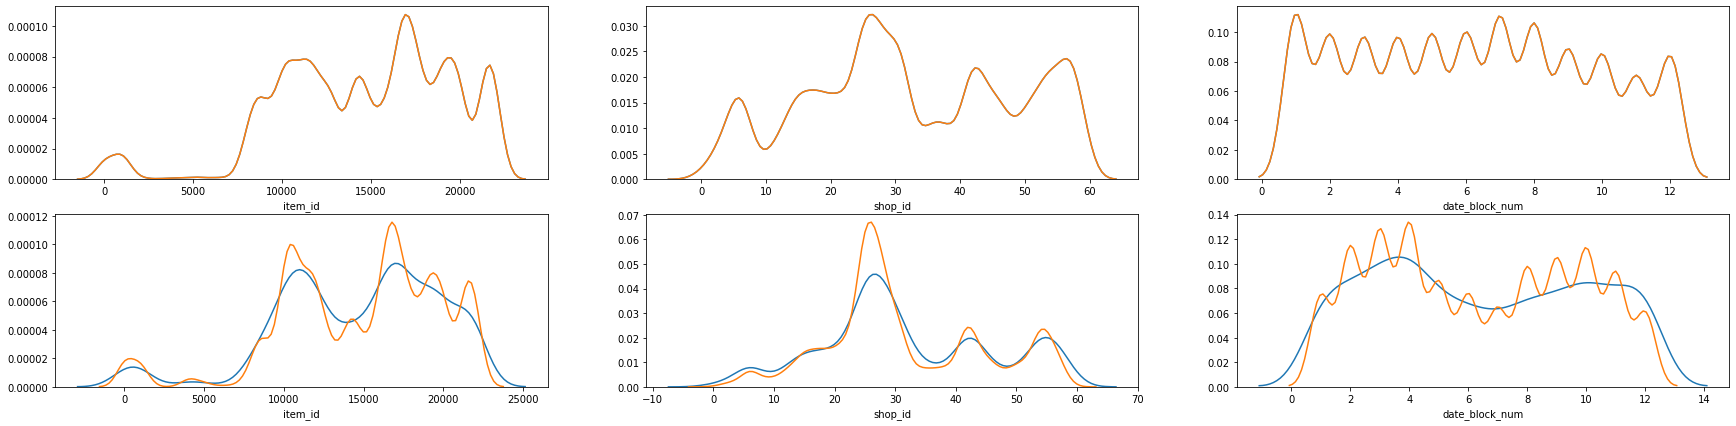

In [29]:
graph_4 = pd.concat([pd.DataFrame(X_train), pd.DataFrame(y_train)], axis=1)
graph_4.columns = ['shop_id', 'date_block_num','item_id', 'class_item_cnt_day']
hist(graph_4)

In [30]:
for x in range(len(models)):
    print(models_name[x])
    fit_predict(models[x], X_train, y_train)

DecisionTreeClassifier(entropy)
   precision    recall  accuracy  sample
1   0.910046  0.973981   0.89043  103001
2   0.432579  0.170836   0.89043  103001
DecisionTreeClassifier(gini)
   precision    recall  accuracy  sample
1   0.910511  0.973994  0.890876  103001
2   0.432579  0.171572  0.890876  103001
RandomForestClassifier(entropy)
   precision    recall  accuracy  sample
1   0.887945  0.972731  0.868679  103001
2   0.419005  0.138085  0.868679  103001
RandomForestClassifier(gini)
   precision    recall  accuracy  sample
1   0.889031  0.972846  0.869795  103001
2   0.420814  0.139766  0.869795  103001
KNeighborsClassifier(n_neighbors = 3)
   precision    recall  accuracy  sample
1   0.892210  0.976283  0.875855  103001
2   0.494118  0.164161  0.875855  103001
KNeighborsClassifier(n_neighbors = 6)
   precision    recall  accuracy  sample
1   0.891008  0.976418  0.874851  103001
2   0.497738  0.163642  0.874851  103001


In [31]:
svmsmote = SVMSMOTE(random_state = 1)
X_train, y_train = svmsmote.fit_resample(X_train_first, y_train_first)

<function print>

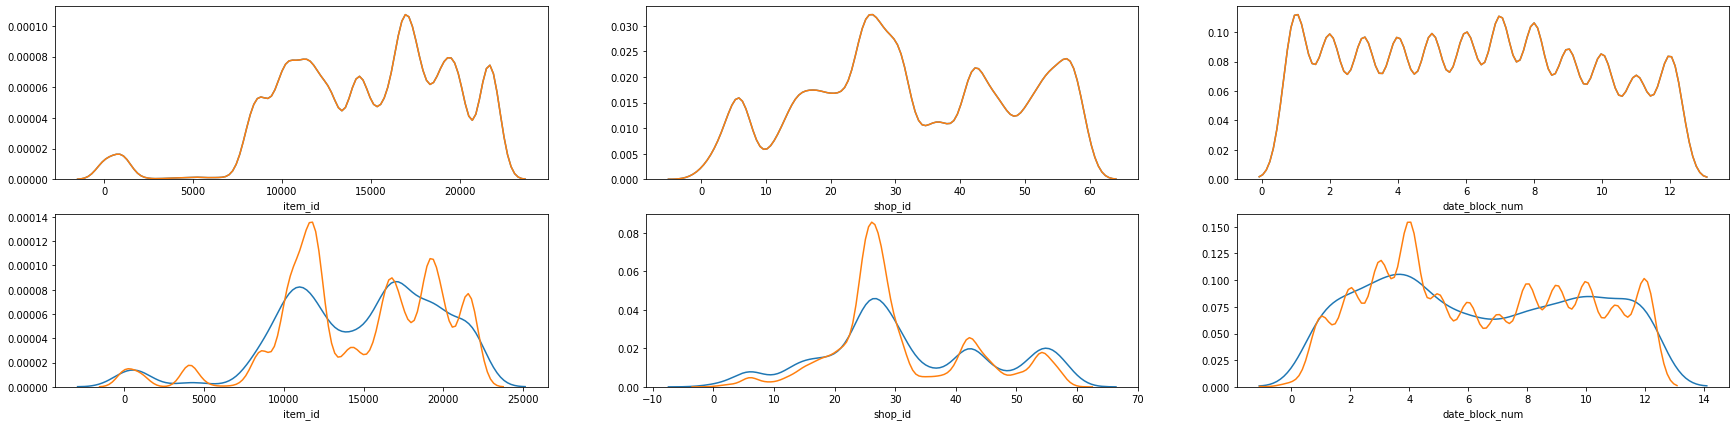

In [32]:
graph_4 = pd.concat([pd.DataFrame(X_train), pd.DataFrame(y_train)], axis=1)
graph_4.columns = ['shop_id', 'date_block_num','item_id', 'class_item_cnt_day']
hist(graph_4)

In [33]:
for x in range(len(models)):
    print(models_name[x])
    fit_predict(models[x], X_train, y_train)

DecisionTreeClassifier(entropy)
   precision    recall  accuracy  sample
1   0.919352  0.973558  0.898721  103001
2   0.417195  0.181425  0.898721  103001
DecisionTreeClassifier(gini)
   precision    recall  accuracy  sample
1   0.919042  0.973109  0.898015  103001
2   0.407240  0.177305  0.898015  103001
RandomForestClassifier(entropy)
   precision    recall  accuracy  sample
1   0.903998  0.972269  0.883217  103001
2   0.398190  0.150892  0.883217  103001
RandomForestClassifier(gini)
   precision    recall  accuracy  sample
1   0.908495  0.971999  0.887158  103001
2   0.389140  0.154122  0.887158  103001
KNeighborsClassifier(n_neighbors = 3)
   precision    recall  accuracy  sample
1   0.901943  0.975796  0.884518  103001
2   0.477828  0.172718  0.884518  103001
KNeighborsClassifier(n_neighbors = 6)
   precision    recall  accuracy  sample
1   0.905665  0.975648  0.887864  103001
2   0.472398  0.176650  0.887864  103001


Единственный метод, который умеет работать с категориальными признаками

In [34]:
X_train_first['add'] = 1
smotenc = SMOTENC([0, 1, 2],random_state = 1)
X_train, y_train = smotenc.fit_resample(X_train_first, y_train_first)

In [35]:
X_train = X_train[:, :-1]

<function print>

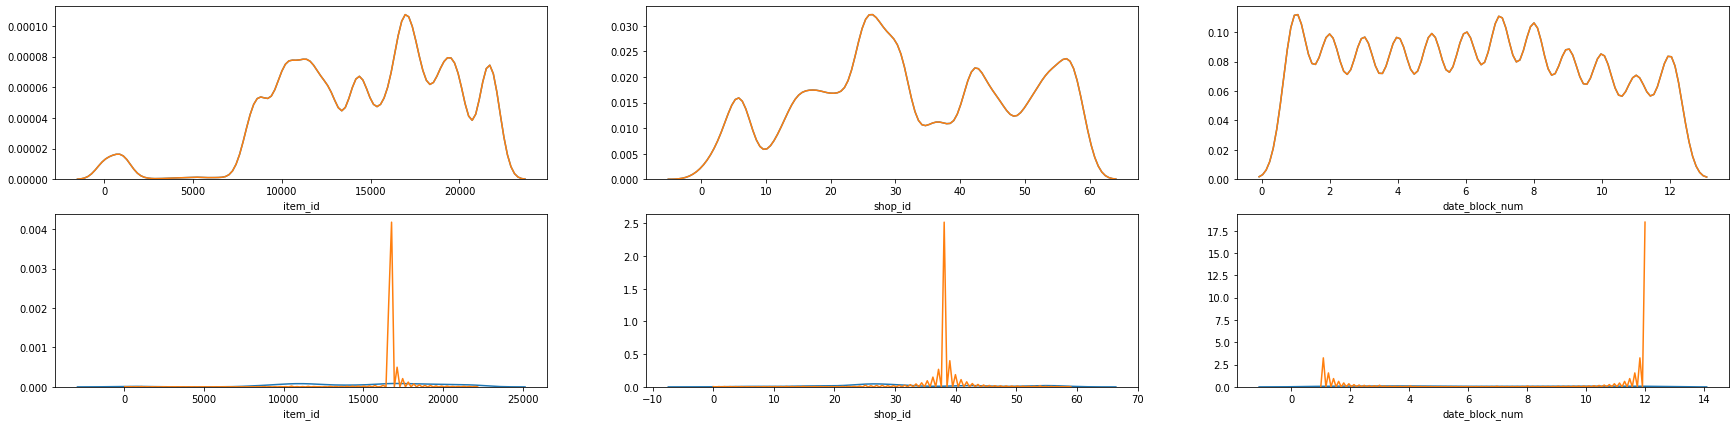

In [36]:
graph_5 = pd.concat([pd.DataFrame(X_train), pd.DataFrame(y_train)], axis=1)
graph_5.columns = ['shop_id', 'date_block_num','item_id', 'class_item_cnt_day']
hist(graph_5)

In [37]:
for x in range(len(models)):
    print(models_name[x])
    fit_predict(models[x], X_train, y_train)

DecisionTreeClassifier(entropy)
   precision    recall  accuracy  sample
1   0.961615  0.965395  0.930138  103001
2   0.195475  0.179104  0.930138  103001
DecisionTreeClassifier(gini)
   precision    recall  accuracy  sample
1   0.961847  0.966080  0.931031  103001
2   0.211765  0.192118  0.931031  103001
RandomForestClassifier(entropy)
   precision    recall  accuracy  sample
1   0.982552  0.960578  0.944601  103001
2   0.058824  0.126214  0.944601  103001
RandomForestClassifier(gini)
   precision    recall  accuracy  sample
1   0.982087  0.960633   0.94423  103001
2   0.060633  0.126654   0.94423  103001
KNeighborsClassifier(n_neighbors = 3)
   precision    recall  accuracy  sample
1   0.984607  0.963792  0.949769  103001
2   0.136652  0.275547  0.949769  103001
KNeighborsClassifier(n_neighbors = 6)
   precision    recall  accuracy  sample
1   0.997712  0.960078  0.958023  103001
2   0.031674  0.372340  0.958023  103001


метод ADASYN не устойчив к выбросам (уделяет большое внимание областям с низкой плотностью)

In [38]:
X_train_first.drop(['add'], axis=1, inplace=True)
ad = ADASYN(random_state = 1)
X_train, y_train = ad.fit_resample(X_train_first, y_train_first)

<function print>

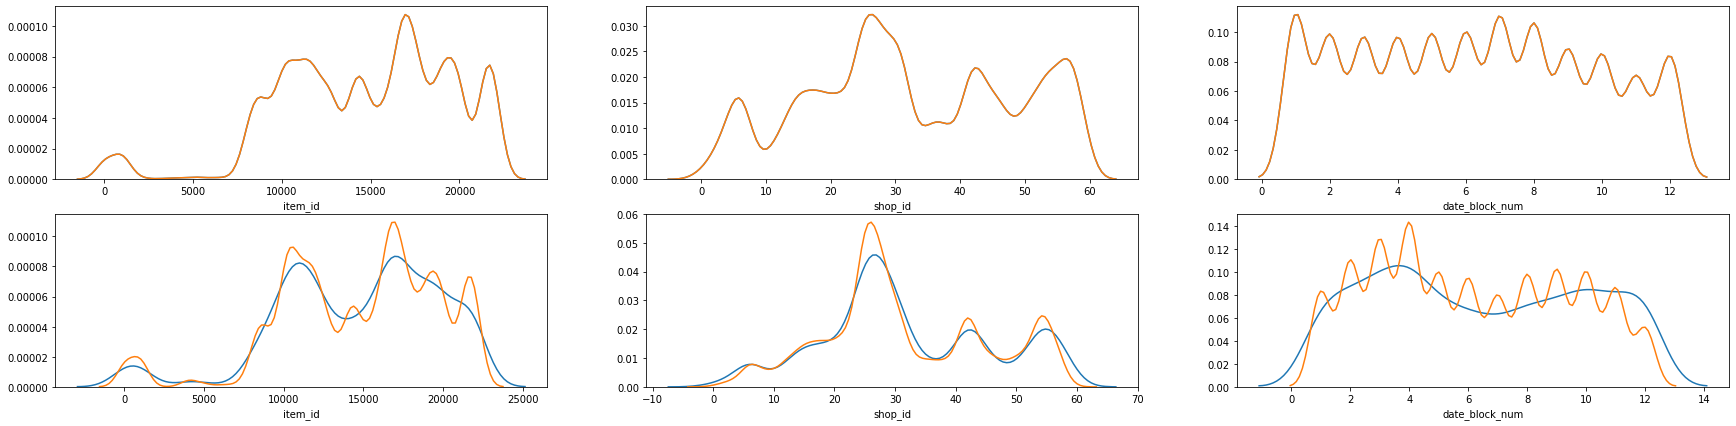

In [39]:
graph_6 = pd.concat([pd.DataFrame(X_train), pd.DataFrame(y_train)], axis=1)
graph_6.columns = ['shop_id', 'date_block_num','item_id', 'class_item_cnt_day']
hist(graph_6)

In [40]:
for x in range(len(models)):
    print(models_name[x])
    fit_predict(models[x], X_train, y_train)

DecisionTreeClassifier(entropy)
   precision    recall  accuracy  sample
1   0.867085  0.975911  0.852023  103001
2   0.500452  0.138910  0.852023  103673
DecisionTreeClassifier(gini)
   precision    recall  accuracy  sample
1   0.865767  0.975364  0.850312  103001
2   0.489593  0.135149  0.850312  103673
RandomForestClassifier(entropy)
   precision    recall  accuracy  sample
1   0.834167  0.974631  0.820159  103001
2   0.493213  0.113024  0.820159  103673
RandomForestClassifier(gini)
   precision    recall  accuracy  sample
1   0.824745  0.974840  0.811533  103001
2   0.503167  0.109535  0.811533  103673
KNeighborsClassifier(n_neighbors = 3)
   precision    recall  accuracy  sample
1   0.844326  0.978741  0.833135  103001
2   0.571946  0.136002  0.833135  103673
KNeighborsClassifier(n_neighbors = 6)
   precision    recall  accuracy  sample
1   0.845450  0.979076  0.834474  103001
2   0.578281  0.138162  0.834474  103673


UNDERSAMPLING

In [41]:
# cc = ClusterCentroids(random_state=0)
# X_train, y_train = cc.fit_resample(X_train, y_train)

In [42]:
rus = RandomUnderSampler(random_state=1)
X_train, y_train = rus.fit_resample(X_train_first, y_train_first)

<function print>

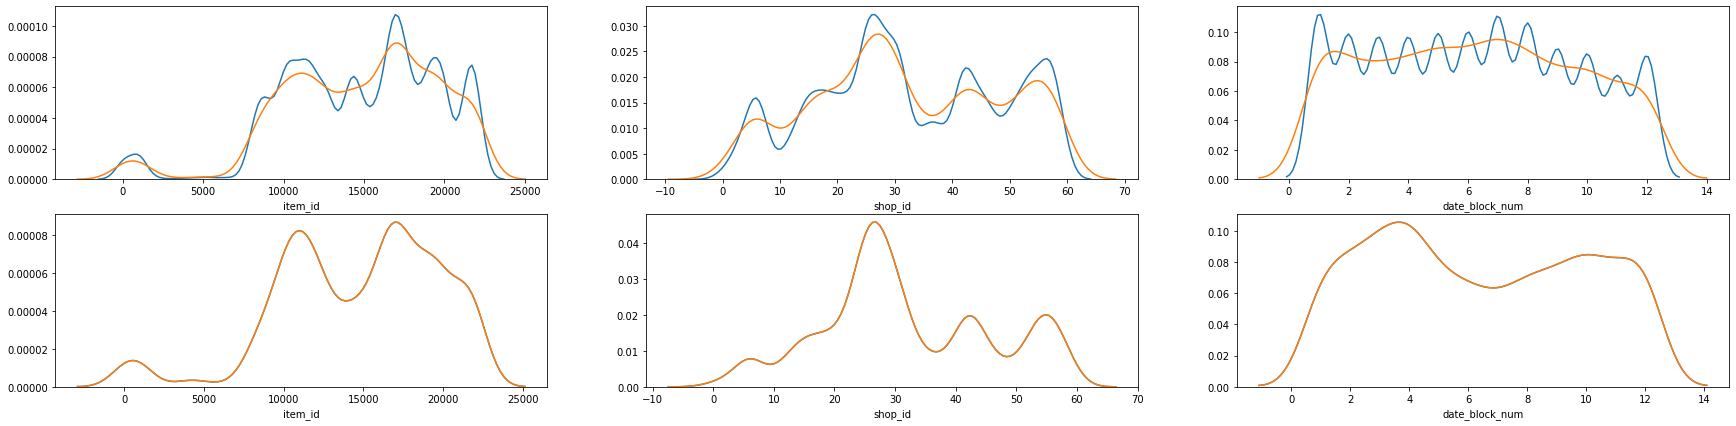

In [43]:
graph_7 = pd.concat([pd.DataFrame(X_train), pd.DataFrame(y_train)], axis=1)
graph_7.columns = ['shop_id', 'date_block_num','item_id', 'class_item_cnt_day']
hist(graph_7)

In [44]:
for x in range(len(models)):
    print(models_name[x])
    fit_predict(models[x], X_train, y_train)

DecisionTreeClassifier(entropy)
   precision    recall  accuracy  sample
1   0.594781  0.973783  0.596074    4579
2   0.626244  0.062102  0.596074    4579
DecisionTreeClassifier(gini)
   precision    recall  accuracy  sample
1   0.600985  0.973863  0.601911    4579
2   0.623529  0.062750  0.601911    4579
RandomForestClassifier(entropy)
   precision    recall  accuracy  sample
1   0.634291  0.975259  0.633886    4579
2   0.624434  0.068168  0.633886    4579
RandomForestClassifier(gini)
   precision    recall  accuracy  sample
1   0.660269  0.977106  0.659392    4579
2   0.638914  0.074567  0.659392    4579
KNeighborsClassifier(n_neighbors = 3)
   precision    recall  accuracy  sample
1   0.613547  0.982796  0.619126    4579
2   0.749321  0.076702  0.619126    4579
KNeighborsClassifier(n_neighbors = 6)
   precision    recall  accuracy  sample
1   0.694894  0.978809  0.693003    4579
2   0.648869  0.083508  0.693003    4579


In [45]:
nm1 = NearMiss(version=2)
X_train, y_train = nm1.fit_resample(X_train_first, y_train_first)

<function print>

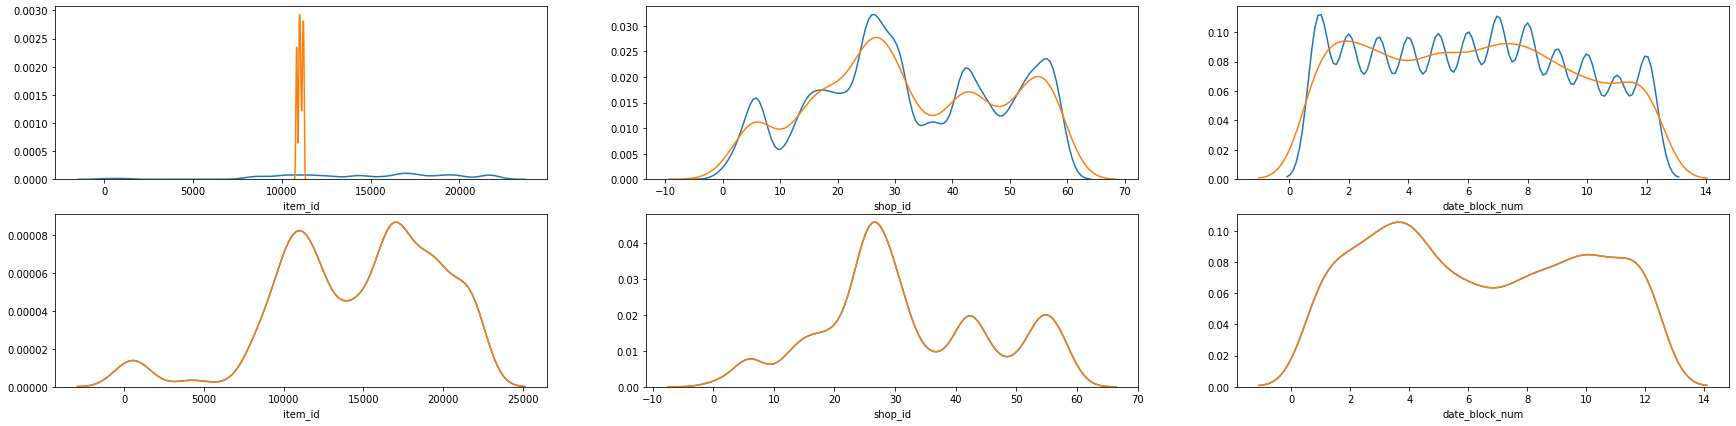

In [46]:
graph_8 = pd.concat([pd.DataFrame(X_train), pd.DataFrame(y_train)], axis=1)
graph_8.columns = ['shop_id', 'date_block_num','item_id', 'class_item_cnt_day']
hist(graph_8)

In [47]:
for x in range(len(models)):
    print(models_name[x])
    fit_predict(models[x], X_train, y_train)

DecisionTreeClassifier(entropy)
   precision    recall  accuracy  sample
1   0.043736  0.964927  0.081499    4579
2   0.962896  0.041357  0.081499    4579
DecisionTreeClassifier(gini)
   precision    recall  accuracy  sample
1   0.043891  0.965047  0.081648    4579
2   0.962896  0.041364  0.081648    4579
RandomForestClassifier(entropy)
   precision    recall  accuracy  sample
1   0.047924  0.962617  0.085254    4579
2   0.956561  0.041270  0.085254    4579
RandomForestClassifier(gini)
   precision    recall  accuracy  sample
1   0.047342  0.960661  0.084622    4579
2   0.954751  0.041171  0.084622    4579
KNeighborsClassifier(n_neighbors = 3)
   precision    recall  accuracy  sample
1   0.044861  0.963364  0.082466    4579
2   0.960181  0.041292  0.082466    4579
KNeighborsClassifier(n_neighbors = 6)
   precision    recall  accuracy  sample
1   0.045597  0.959217  0.082949    4579
2   0.954751  0.041099  0.082949    4579


In [48]:
enn = EditedNearestNeighbours()
X_train, y_train = enn.fit_resample(X_train_first, y_train_first)

<function print>

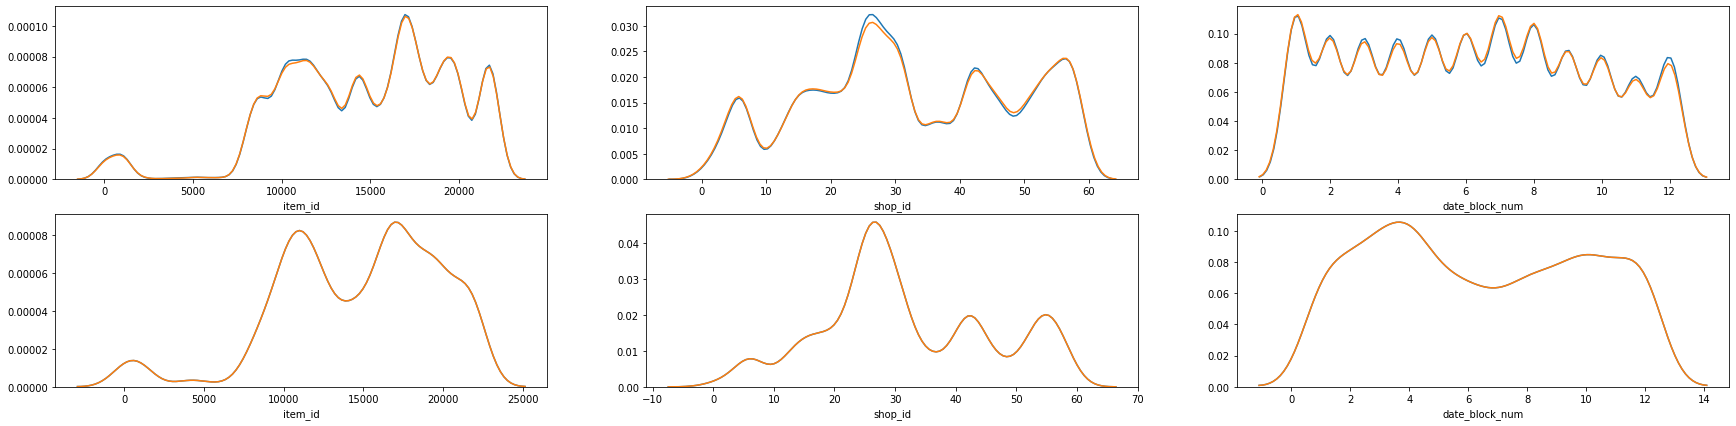

In [49]:
graph_9 = pd.concat([pd.DataFrame(X_train), pd.DataFrame(y_train)], axis=1)
graph_9.columns = ['shop_id', 'date_block_num','item_id', 'class_item_cnt_day']
hist(graph_9)

In [50]:
for x in range(len(models)):
    print(models_name[x])
    fit_predict(models[x], X_train, y_train)

DecisionTreeClassifier(entropy)
   precision    recall  accuracy  sample
1   0.934086  0.971333  0.910358   92238
2   0.356561  0.188157  0.910358    4579
DecisionTreeClassifier(gini)
   precision    recall  accuracy  sample
1   0.935675  0.971458  0.911957   92238
2   0.358371  0.192701  0.911957    4579
RandomForestClassifier(entropy)
   precision    recall  accuracy  sample
1   0.973363  0.961876  0.937463   92238
2   0.099548  0.138018  0.937463    4579
RandomForestClassifier(gini)
   precision    recall  accuracy  sample
1   0.973285  0.961799  0.937314   92238
2   0.097738  0.135508  0.937314    4579
KNeighborsClassifier(n_neighbors = 3)
   precision    recall  accuracy  sample
1   0.950176  0.969268  0.923334   92238
2   0.296833  0.203348  0.923334    4579
KNeighborsClassifier(n_neighbors = 6)
   precision    recall  accuracy  sample
1   0.981932  0.963881   0.94739   92238
2   0.141176  0.250804   0.94739    4579


In [51]:
renn = RepeatedEditedNearestNeighbours()
X_train, y_train = renn.fit_resample(X_train_first, y_train_first)

<function print>

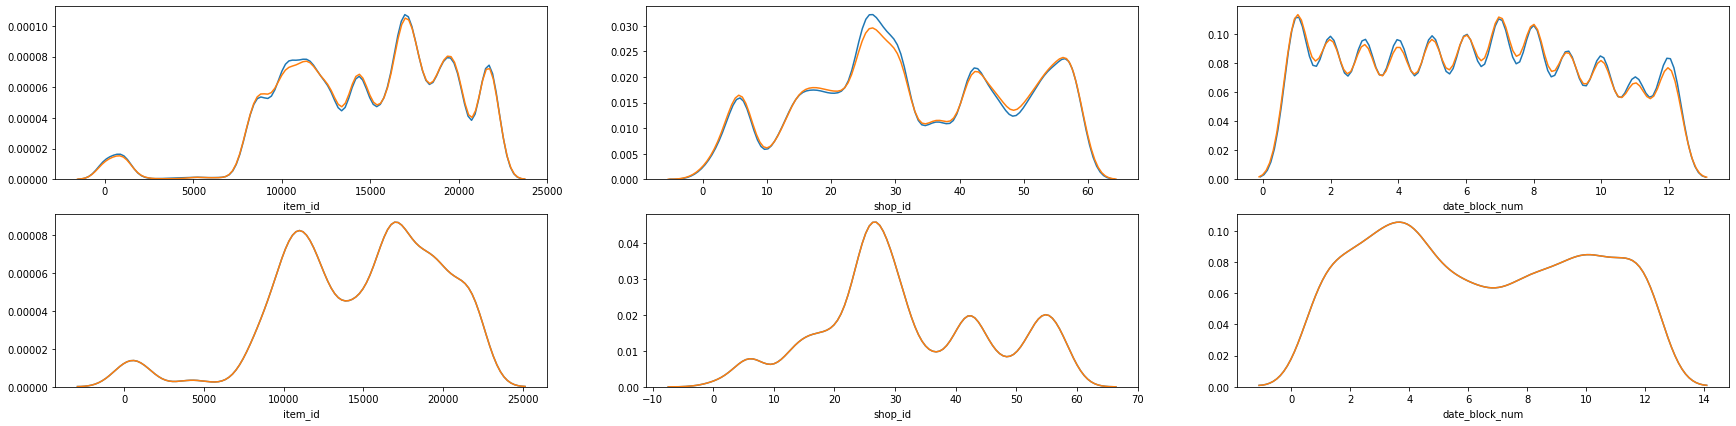

In [52]:
graph_10 = pd.concat([pd.DataFrame(X_train), pd.DataFrame(y_train)], axis=1)
graph_10.columns = ['shop_id', 'date_block_num','item_id', 'class_item_cnt_day']
hist(graph_10)

In [53]:
for x in range(len(models)):
    print(models_name[x])
    fit_predict(models[x], X_train, y_train)

DecisionTreeClassifier(entropy)
   precision    recall  accuracy  sample
1   0.904928  0.974122  0.885782   84586
2   0.438914  0.165134  0.885782    4579
DecisionTreeClassifier(gini)
   precision    recall  accuracy  sample
1   0.907099  0.974061  0.887753   84586
2   0.436199  0.167477  0.887753    4579
RandomForestClassifier(entropy)
   precision    recall  accuracy  sample
1   0.966345  0.962538  0.931663   84586
2   0.122172  0.134596  0.931663    4579
RandomForestClassifier(gini)
   precision    recall  accuracy  sample
1   0.964484  0.962543  0.929952   84586
2   0.123982  0.130104  0.929952    4579
KNeighborsClassifier(n_neighbors = 3)
   precision    recall  accuracy  sample
1   0.911675  0.974027  0.891991   84586
2   0.432579  0.173440  0.891991    4579
KNeighborsClassifier(n_neighbors = 6)
   precision    recall  accuracy  sample
1   0.958784  0.967676  0.929767   84586
2   0.252489  0.207899  0.929767    4579


In [54]:
allknn = AllKNN()
X_train, y_train = allknn.fit_resample(X_train_first, y_train_first)

<function print>

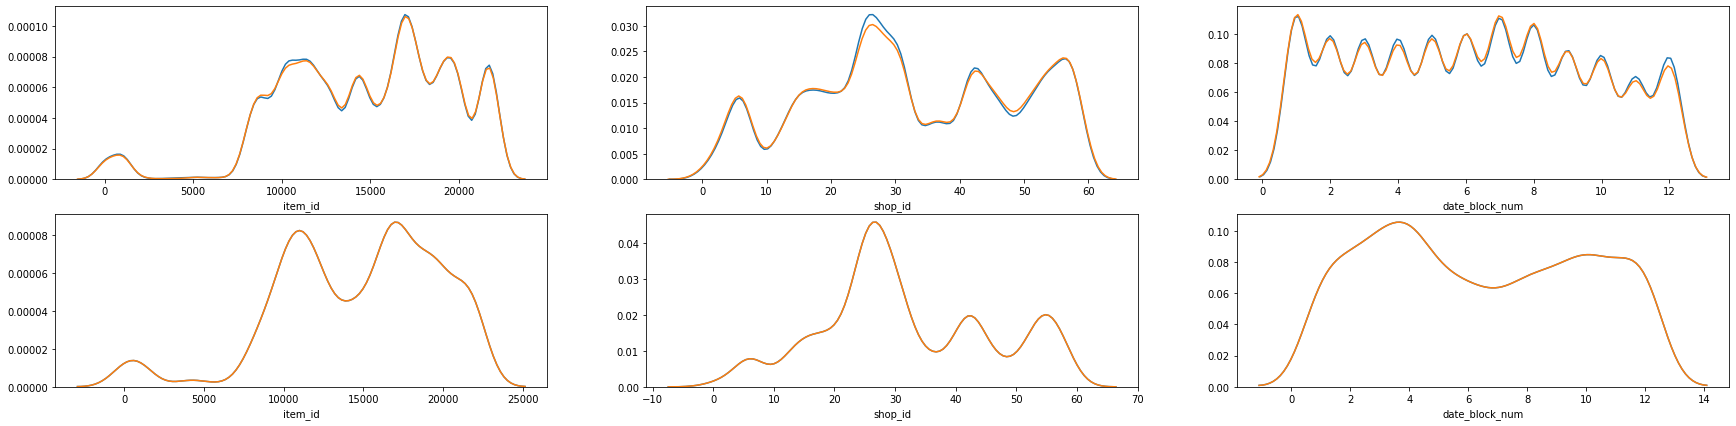

In [55]:
graph_11 = pd.concat([pd.DataFrame(X_train), pd.DataFrame(y_train)], axis=1)
graph_11.columns = ['shop_id', 'date_block_num','item_id', 'class_item_cnt_day']
hist(graph_11)

In [56]:
for x in range(len(models)):
    print(models_name[x])
    fit_predict(models[x], X_train, y_train)

DecisionTreeClassifier(entropy)
   precision    recall  accuracy  sample
1   0.924198  0.972779  0.902513   89324
2   0.396380  0.183034  0.902513    4579
DecisionTreeClassifier(gini)
   precision    recall  accuracy  sample
1   0.924702  0.972674  0.902885   89324
2   0.393665  0.183004  0.902885    4579
RandomForestClassifier(entropy)
   precision    recall  accuracy  sample
1   0.970920  0.962338  0.935678   89324
2   0.113122  0.142857  0.935678    4579
RandomForestClassifier(gini)
   precision    recall  accuracy  sample
1   0.968477  0.962136  0.933224   89324
2   0.110407  0.130481  0.933224    4579
KNeighborsClassifier(n_neighbors = 3)
   precision    recall  accuracy  sample
1   0.937342  0.971079  0.913147   89324
2   0.348416  0.192404  0.913147    4579
KNeighborsClassifier(n_neighbors = 6)
   precision    recall  accuracy  sample
1   0.974914  0.965554  0.942594   89324
2   0.188235  0.243275  0.942594    4579


In [57]:
# cnn = CondensedNearestNeighbour(random_state=0)
# X_train, y_train = cnn.fit_resample(X_train_first, y_train_first)

<function print>

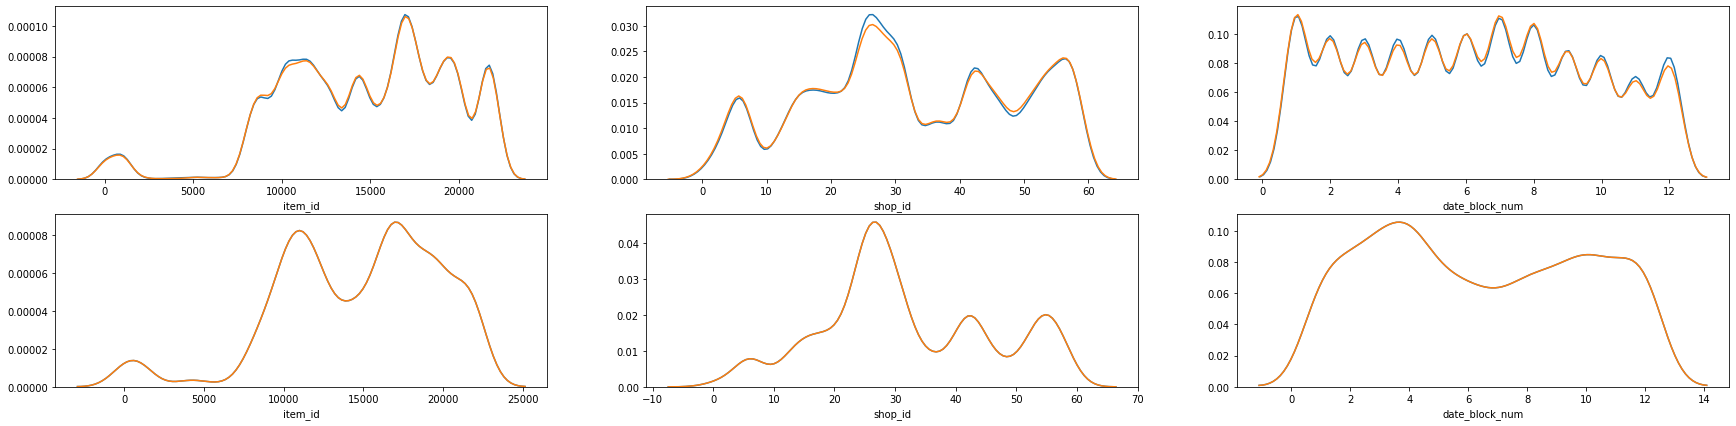

In [58]:
graph_12 = pd.concat([pd.DataFrame(X_train), pd.DataFrame(y_train)], axis=1)
graph_12.columns = ['shop_id', 'date_block_num','item_id', 'class_item_cnt_day']
hist(graph_12)

In [59]:
for x in range(len(models)):
    print(models_name[x])
    fit_predict(models[x], X_train, y_train)

DecisionTreeClassifier(entropy)
   precision    recall  accuracy  sample
1   0.924276  0.972980  0.902774   89324
2   0.400905  0.184891  0.902774    4579
DecisionTreeClassifier(gini)
   precision    recall  accuracy  sample
1   0.923656  0.972604  0.901844   89324
2   0.392760  0.180608  0.901844    4579
RandomForestClassifier(entropy)
   precision    recall  accuracy  sample
1   0.969757  0.962295  0.934563   89324
2   0.113122  0.138122  0.934563    4579
RandomForestClassifier(gini)
   precision    recall  accuracy  sample
1   0.968128  0.962159  0.932927   89324
2   0.111312  0.130159  0.932927    4579
KNeighborsClassifier(n_neighbors = 3)
   precision    recall  accuracy  sample
1   0.937342  0.971079  0.913147   89324
2   0.348416  0.192404  0.913147    4579
KNeighborsClassifier(n_neighbors = 6)
   precision    recall  accuracy  sample
1   0.974914  0.965554  0.942594   89324
2   0.188235  0.243275  0.942594    4579


In [60]:
oss = OneSidedSelection(random_state=0)
X_train, y_train = oss.fit_resample(X_train_first, y_train_first)

<function print>

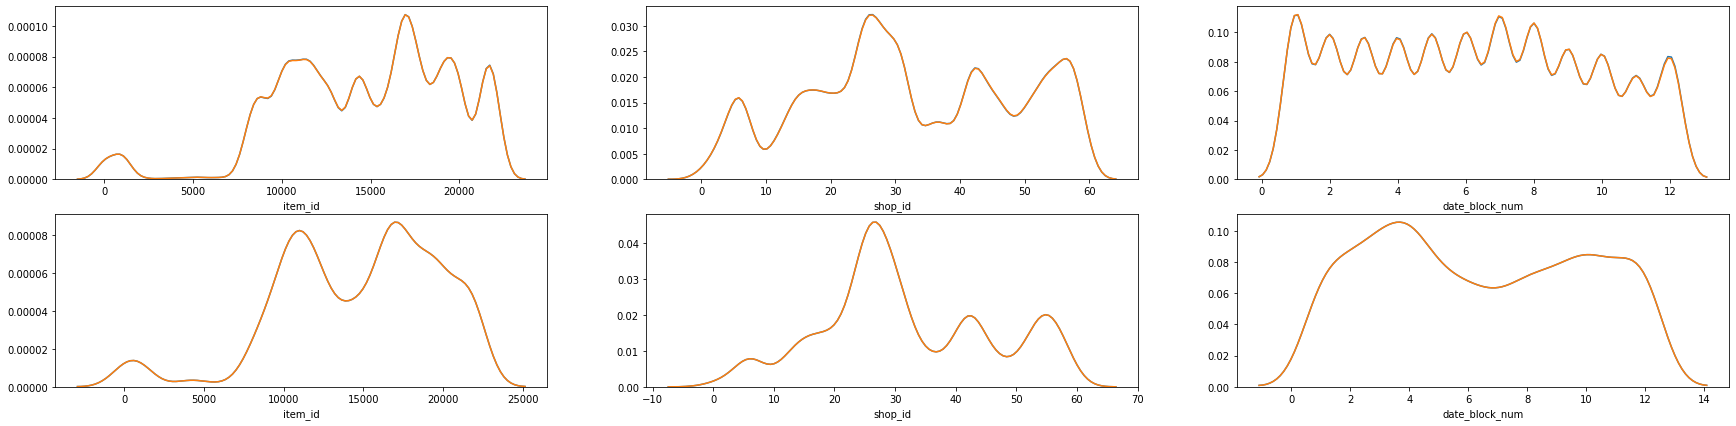

In [61]:
graph_13 = pd.concat([pd.DataFrame(X_train), pd.DataFrame(y_train)], axis=1)
graph_13.columns = ['shop_id', 'date_block_num','item_id', 'class_item_cnt_day']
hist(graph_13)

In [62]:
for x in range(len(models)):
    print(models_name[x])
    fit_predict(models[x], X_train, y_train)

DecisionTreeClassifier(entropy)
   precision    recall  accuracy  sample
1   0.957621  0.966427  0.927461  101571
2   0.223529  0.184328  0.927461    4579
DecisionTreeClassifier(gini)
   precision    recall  accuracy  sample
1   0.959211  0.967009  0.929506  101571
2   0.236199  0.198781  0.929506    4579
RandomForestClassifier(entropy)
   precision    recall  accuracy  sample
1   0.981001  0.961430  0.944044  101571
2   0.081448  0.155172  0.944044    4579
RandomForestClassifier(gini)
   precision    recall  accuracy  sample
1   0.979644  0.960684  0.942036  101571
2   0.064253  0.119128  0.942036    4579
KNeighborsClassifier(n_neighbors = 3)
   precision    recall  accuracy  sample
1   0.980575  0.964421  0.946684  101571
2   0.155656  0.255572  0.946684    4579
KNeighborsClassifier(n_neighbors = 6)
   precision    recall  accuracy  sample
1   0.997053  0.960375  0.957726  101571
2   0.039819  0.366667  0.957726    4579


In [63]:
ncr = NeighbourhoodCleaningRule()
X_train, y_train = ncr.fit_resample(X_train_first, y_train_first)

<function print>

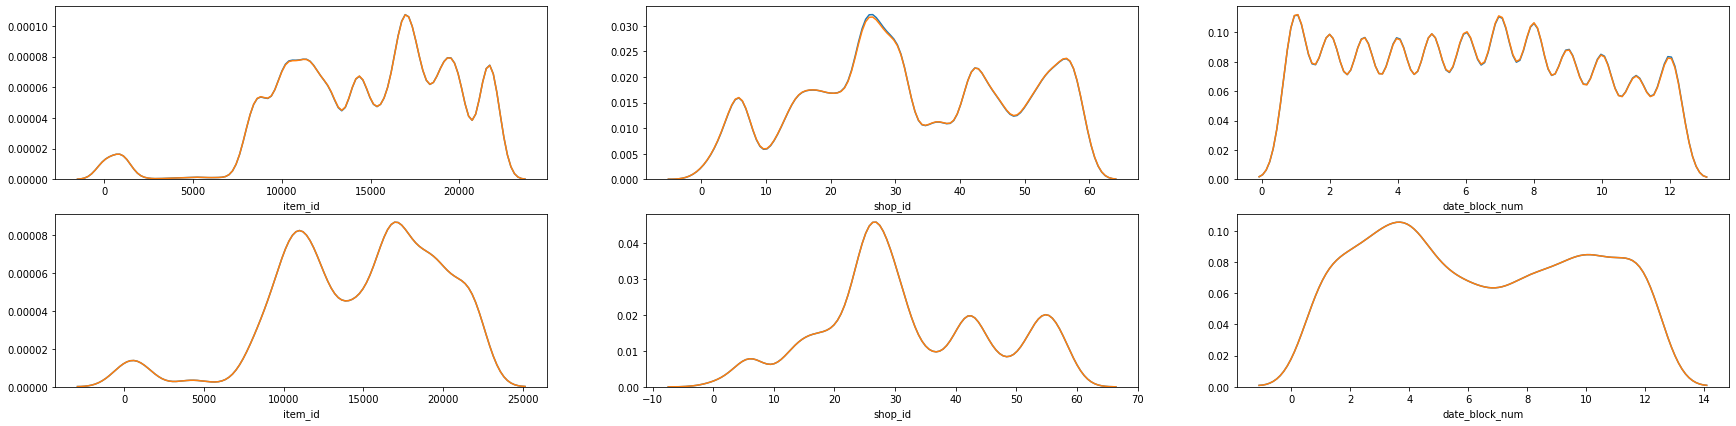

In [64]:
graph_14 = pd.concat([pd.DataFrame(X_train), pd.DataFrame(y_train)], axis=1)
graph_14.columns = ['shop_id', 'date_block_num','item_id', 'class_item_cnt_day']
hist(graph_14)

In [65]:
for x in range(len(models)):
    print(models_name[x])
    fit_predict(models[x], X_train, y_train)

DecisionTreeClassifier(entropy)
   precision    recall  accuracy  sample
1   0.956147  0.967135  0.926792  101539
2   0.241629  0.190987  0.926792    4579
DecisionTreeClassifier(gini)
   precision    recall  accuracy  sample
1   0.958900  0.967491  0.929692  101539
2   0.247964  0.205397  0.929692    4579
RandomForestClassifier(entropy)
   precision    recall  accuracy  sample
1   0.980652  0.960942  0.943226  101539
2   0.069683  0.133681  0.943226    4579
RandomForestClassifier(gini)
   precision    recall  accuracy  sample
1   0.977744  0.960831  0.940437  101539
2   0.069683  0.118280  0.940437    4579
KNeighborsClassifier(n_neighbors = 3)
   precision    recall  accuracy  sample
1   0.974991  0.964779  0.941887  101539
2   0.169231  0.224760  0.941887    4579
KNeighborsClassifier(n_neighbors = 6)
   precision    recall  accuracy  sample
1   0.994262  0.961312  0.956127  101539
2   0.066063  0.330317  0.956127    4579


In [66]:
smote_enn = SMOTEENN(random_state=0)
X_train, y_train = smote_enn.fit_resample(X_train_first, y_train_first)

<function print>

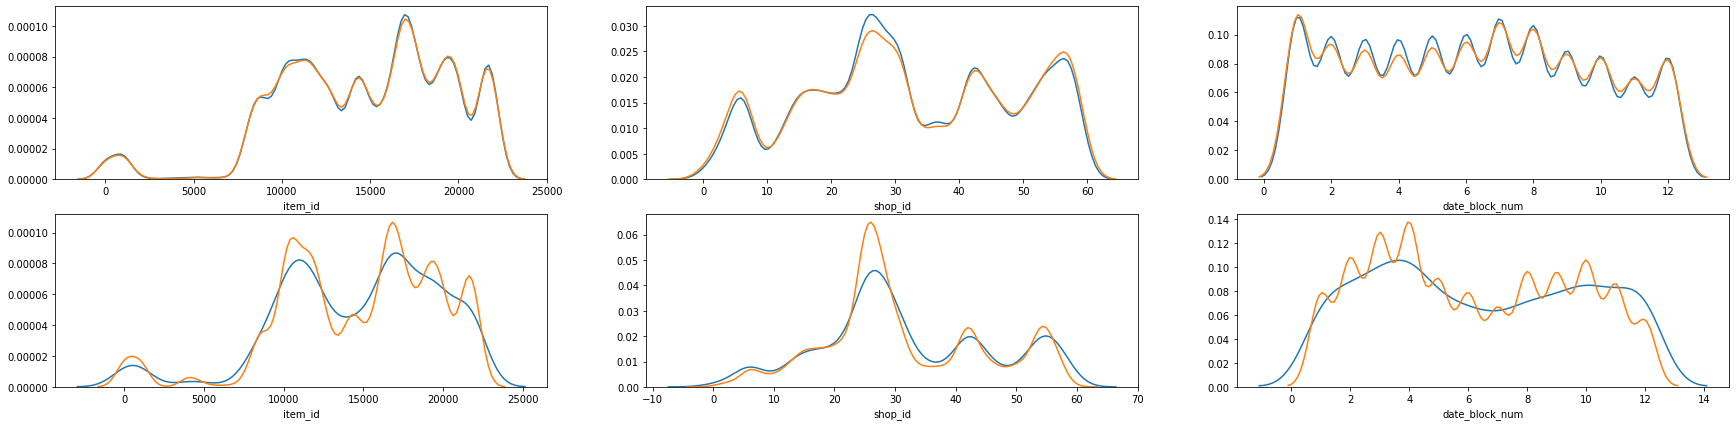

In [67]:
graph_15 = pd.concat([pd.DataFrame(X_train), pd.DataFrame(y_train)], axis=1)
graph_15.columns = ['shop_id', 'date_block_num','item_id', 'class_item_cnt_day']
hist(graph_15)

In [68]:
for x in range(len(models)):
    print(models_name[x])
    fit_predict(models[x], X_train, y_train)

DecisionTreeClassifier(entropy)
   precision    recall  accuracy  sample
1   0.846807  0.977837  0.834697   79059
2   0.552036  0.133743  0.834697   83049
DecisionTreeClassifier(gini)
   precision    recall  accuracy  sample
1   0.847078  0.977626  0.834771   79059
2   0.547511  0.132996  0.834771   83049
RandomForestClassifier(entropy)
   precision    recall  accuracy  sample
1   0.853127  0.974533  0.837783   79059
2   0.479638  0.122742  0.837783   83049
RandomForestClassifier(gini)
   precision    recall  accuracy  sample
1   0.854833  0.974496  0.839344   79059
2   0.477828  0.123596  0.839344   83049
KNeighborsClassifier(n_neighbors = 3)
   precision    recall  accuracy  sample
1   0.804467  0.981596  0.798037   79059
2   0.647964  0.124327  0.798037   83049
KNeighborsClassifier(n_neighbors = 6)
   precision    recall  accuracy  sample
1   0.799116  0.982036  0.793352   79059
2   0.658824  0.123202  0.793352   83049


In [69]:
smote_tomek = SMOTETomek(random_state=0)
X_train, y_train = smote_tomek.fit_resample(X_train_first, y_train_first)

<function print>

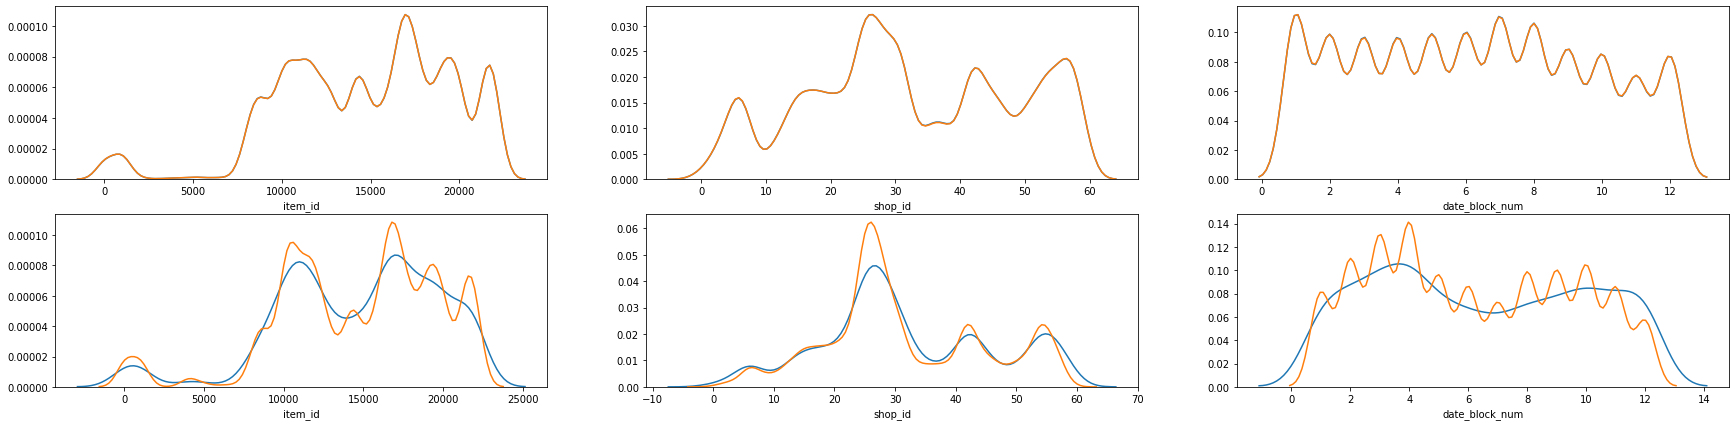

In [70]:
graph_16 = pd.concat([pd.DataFrame(X_train), pd.DataFrame(y_train)], axis=1)
graph_16.columns = ['shop_id', 'date_block_num','item_id', 'class_item_cnt_day']
hist(graph_16)

In [71]:
for x in range(len(models)):
    print(models_name[x])
    fit_predict(models[x], X_train, y_train)

DecisionTreeClassifier(entropy)
   precision    recall  accuracy  sample
1   0.877864  0.975821  0.862024  102094
2   0.492308  0.147266  0.862024  102094
DecisionTreeClassifier(gini)
   precision    recall  accuracy  sample
1   0.875305  0.975794  0.859607  102094
2   0.493213  0.144908  0.859607  102094
RandomForestClassifier(entropy)
   precision    recall  accuracy  sample
1   0.850103  0.974618  0.835031  102094
2   0.483258  0.121364  0.835031  102094
RandomForestClassifier(gini)
   precision    recall  accuracy  sample
1   0.844054  0.974440  0.829231  102094
2   0.483258  0.117208  0.829231  102094
KNeighborsClassifier(n_neighbors = 3)
   precision    recall  accuracy  sample
1   0.850995  0.979297  0.839865  102094
2   0.580090  0.142953  0.839865  102094
KNeighborsClassifier(n_neighbors = 6)
   precision    recall  accuracy  sample
1   0.855027  0.979001  0.843397  102094
2   0.571946  0.144589  0.843397  102094


Рандомная выборка 10% данных из мажоритарного класса

In [73]:
films_2 = films.copy()
films_2 = films_2[films_2['class_item_cnt_day'] == 1]
films_2['class_item_cnt_day'].count()

128792

In [74]:
films_2 = films_2.sample(frac=1)
films_2['class_item_cnt_day'].count()

128792

In [75]:
films_3 = films.drop(np.where(films['class_item_cnt_day'] == 1)[0])
pd.Series(films_3['class_item_cnt_day']).value_counts()

2    5684
Name: class_item_cnt_day, dtype: int64

In [76]:
films_3 = pd.concat([films_2, films_3])
pd.Series(films_3['class_item_cnt_day']).value_counts()

1    128792
2      5684
Name: class_item_cnt_day, dtype: int64

In [77]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(films_3.drop('class_item_cnt_day', axis=1), films_3['class_item_cnt_day'], test_size=0.2)

In [78]:
print(pd.Series(y_train_2).value_counts())

1    103052
2      4528
Name: class_item_cnt_day, dtype: int64


<function print>

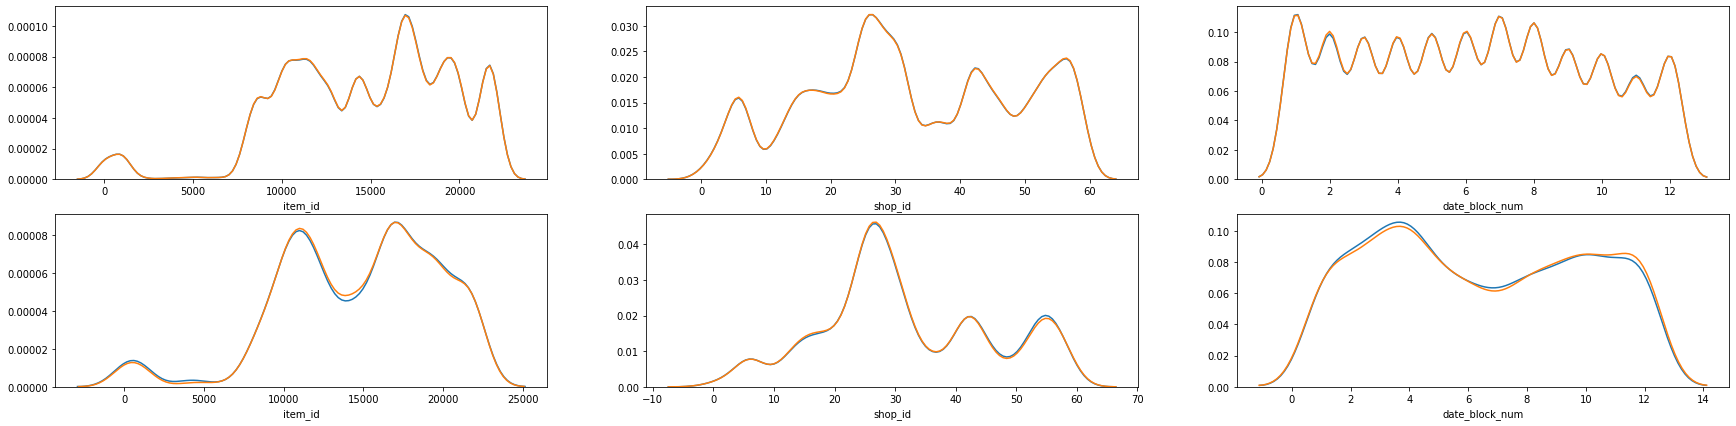

In [79]:
graph_17 = pd.concat([pd.DataFrame(X_train_2), pd.DataFrame(y_train_2)], axis=1)
graph_17.columns = ['shop_id', 'date_block_num','item_id', 'class_item_cnt_day']
hist(graph_17)

In [80]:
smote_2 = SMOTE(random_state = 2)
X_train, y_train = smote_2.fit_resample(X_train_2, y_train_2)

In [81]:
pd.Series(y_train).value_counts()

2    103052
1    103052
dtype: int64

<function print>

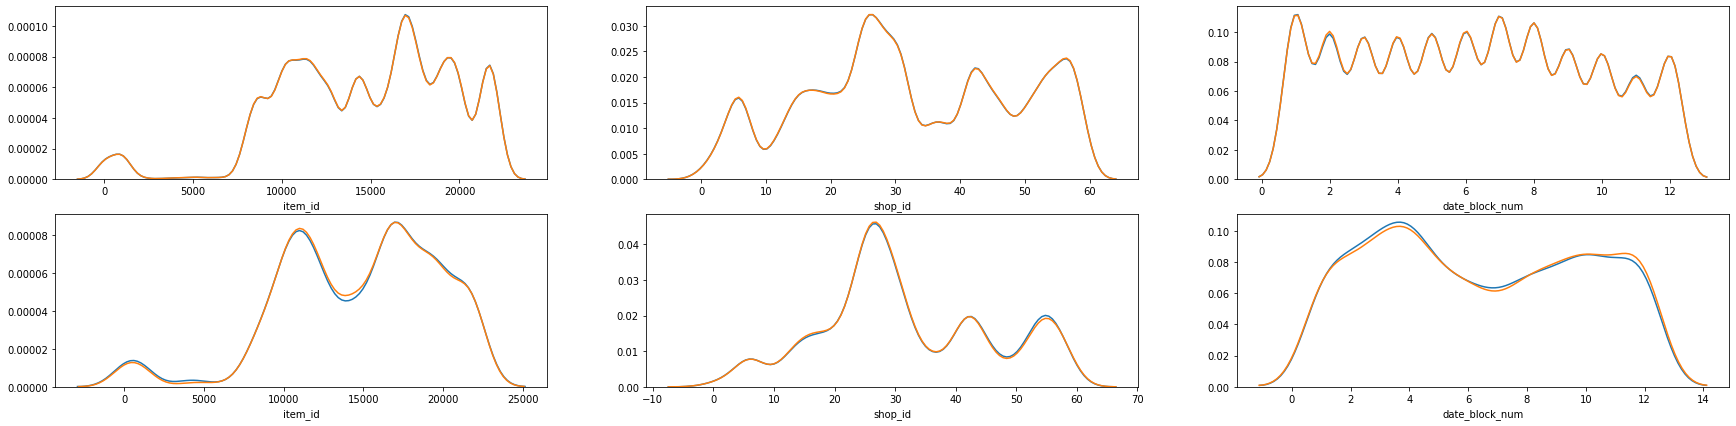

In [82]:
graph_18 = pd.concat([pd.DataFrame(X_train_2), pd.DataFrame(y_train_2)], axis=1)
graph_18.columns = ['shop_id', 'date_block_num','item_id', 'class_item_cnt_day']
hist(graph_18)

In [83]:
for x in range(len(models)):
    print(models_name[x])
    fit_predict(models[x], X_train, y_train)

DecisionTreeClassifier(entropy)
   precision    recall  accuracy  sample
1   0.946803  0.993329  0.942891  103052
2   0.851584  0.406831  0.942891  103052
DecisionTreeClassifier(gini)
   precision    recall  accuracy  sample
1   0.947075  0.993209   0.94304  103052
2   0.848869  0.407295   0.94304  103052
RandomForestClassifier(entropy)
   precision    recall  accuracy  sample
1   0.929976  0.992633  0.926234  103052
2   0.838914  0.339188  0.926234  103052
RandomForestClassifier(gini)
   precision    recall  accuracy  sample
1   0.930906  0.992477  0.926978  103052
2   0.835294  0.341220  0.926978  103052
KNeighborsClassifier(n_neighbors = 3)
   precision    recall  accuracy  sample
1   0.898026  0.994376  0.897345  103052
2   0.881448  0.270255  0.897345  103052
KNeighborsClassifier(n_neighbors = 6)
   precision    recall  accuracy  sample
1   0.887907  0.993579  0.887009  103052
2   0.866063  0.248701  0.887009  103052


In [84]:
test = pd.merge(df_items, df_item_categories, how='left', left_on='item_category_id', right_on='item_category_id')
test_2 = pd.merge(test, df_test, how='left', left_on='item_id', right_on='item_id')
test_2

,item_name,item_id,item_category_id,item_category_name,ID,shop_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино - DVD,NaN,NaN
1,!ABBYY FineReader 12 Professional Edition Full...,1,76,Программы - Для дома и офиса (Цифра),NaN,NaN
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD,NaN,NaN
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD,NaN,NaN
4,***КОРОБКА (СТЕКЛО) D,4,40,Кино - DVD,NaN,NaN
...,...,...,...,...,...,...
231265,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49,Книги - Методические материалы 1С,199377.0,44.0
231266,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49,Книги - Методические материалы 1С,204477.0,39.0
231267,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49,Книги - Методические материалы 1С,209577.0,45.0
231268,Яйцо для Little Inu,22168,62,"Подарки - Гаджеты, роботы, спорт",NaN,NaN
